In [1]:
import warnings
warnings.simplefilter("ignore")

# 가우시안 혼합 모형과 EM 방법

## 가우시안 혼합 모형

실수값을 출력하는 **확률변수 X가 사실 눈에 보이지 않는(관측되지 않는) K-클래스 카테고리 확률변수 Z의 값에 따라 다른 기댓값과 분산을 가지는 복수의 가우시안 정규 분포들로 이루어진 모형**을 가우시안 혼합(Gaussian Mixture) 모형이라고 한다. 

$$ p(x) = \sum_Z p(z)p(x|z) = \sum_{k=1}^{K} \theta_k \mathcal{N}(x|\mu_k, \Sigma_k) $$

* $p(x)$ : 전체 분포
* $p(x|z)$ : 혼합 모형의 각 성분(component)이 되는 개별적인 연속 확률분포. 여기에서는 가우시안 정규 분포
* $p(z)$ : 카테고리 확률분포
* $\theta_k$: 카테고리 확률분포의 모수. 모든 성분 중 특정한 $Z$가 선택될 확률
* $\sum\theta_k = 1$ : 카테고리 확률분포의 모수 제한 조건

### 베르누이-가우시안 혼합 모형

카테고리가 두 개인 가우시안 혼합 모형은 베르누이-가우시안 혼합 모형(Bernouilli Gaussian-Mixuture Model)이라고 한다.

<img src="https://datascienceschool.net/upfiles/16f53a04ffdf42febe4a175c1138b701.png" style="width: 80%">

- 하나의 가우시안 정규분포로 이루어진 확률분포를 uni-modal, 가우시안 혼합모형처럼 두개 이상의 가우시안 정규분포가 합쳐져 나타나는 확률분포를 multi-modal 이라고 한다. 카테고리 확률변수 $z$값에 의해 $x_1$이 선택되면 $x_2$는 선택되지 않는다. 가우시안 혼합모형의 확률 밀도함수는 두 개의 확률분포에서 선택된 샘플의 pdf가 더해져 만들어진다. 하지만 최종 확률밀도함수에서 임의의 값이 어느 클래스의 정규분포에서 추출되었는지는 알 수 없다. 

- 카테고리 확률분포 값에 따라 나타나는 정규분포를 그냥 더하면 확률변수의 값이 더해진 새로운 하나의 정규분포가 만들어지므로 가우시안 혼합모형이 되지 않는다.

- 우리의 목적은 확률분포의 모수를 추정하여 확률모형을 알아내고 어떤 특징을 가지는지 알고자 하는 것이다. 그래서 샘플데이터 없이도 알아낸 확률모형으로 새로운 샘플 데이터를 얻을 수 있다.

다음은 2개의 카테고리와 2차원 가우시안 정규 분포를 가지는 가우시안 혼합 모형 데이터의 예이다.

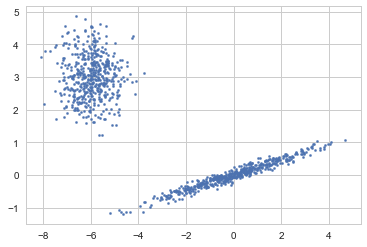

In [1]:
from numpy.random import randn
%matplotlib inline

n_samples = 500

mu1 = np.array([0, 0])
mu2 = np.array([-6, 3])
sigma1 = np.array([[0., -0.1], [1.7, .4]])
sigma2 = np.eye(2)

np.random.seed(0)
X = np.r_[1.0 * np.dot(randn(n_samples, 2), sigma1) + mu1,
          0.7 * np.dot(randn(n_samples, 2), sigma2) + mu2,
         ]
# np.r_ 은 np.concatenate나 np.vstack와 동일한 기능

plt.scatter(X[:, 0], X[:, 1], s=5)
plt.show()

## 가우시안 혼합모형의 모수 추정과 내재변수모형

데이터로부터 가우시안 혼합모형의 모수를 추정한다는 것은 그 카테고리 분포의 모수($\theta_k$) 및 각 카테고리에서의 가우시안 정규 분포 모수($\mu_k, \sum_k$)를 모두 추정하는 것을 말한다. 이 때 어려운 점은 likelihood 함수가 선형대수 방법으로 쉽게 구할 수 없는 복잡한 형태를 가진다는 점이다. 

$N$개의 데이터에 대한 $X$의 결합 확률 분포, 즉 likelihood 는 다음과 같다.

$$ \prod_{i=1}^N p(x_i) = \prod_{i=1}^N \sum_{z_i} p(z_i)p(x_i|z_i)  = \prod_{i=1}^N \sum_{k=1}^{K} \theta_k \mathcal{N}(x_i|\mu_k, \Sigma_k)$$

$ \prod_{i=1}^N p(x_i) $ 는 전체 데이터가 나올 확률이다. Log likelihood는 다음과 같아진다.

$$  LL = \sum_{i=1}^N \log \left( \sum_{k=1}^{K} \theta_k \mathcal{N}(x_i|\mu_k, \Sigma_k) \right) $$



미분값이 0이 되는 모수값을 쉽게 구할 수 있는 형태가 아니라는 것을 알 수 있다.



만약 데이터 $x_i$가 어떤 카테고리 $z_i$에 속하는지를 안다면 그에 해당하는 가우시안 정규 분포 함수

$$p(X=x_i|Z=z_i) = \mathcal{N}(x_i |\mu_{z_i}, \Sigma_{z_i})$$

를 사용하여 로그 함수 내부의 덧셈이 없어지고 likelihood 함수를 쉽게 정의할 수 있을 것이다. 하지만 실제로는 데이터 $x_i$가 가지고 있는 카테고리 값 $z_i$를 알 수가 없기 때문에 likelihood 함수가 위와 같이 로그 함수의 내부에 덧셈이 들어가는 복잡한 비선형 함수가 된다. 가우시안 혼합모형은 수치적 최적화는 복잡해서 어렵기 때문에 Expectation Maximization을 이용한다.

이렇게 관측 데이터가 보이지 않는, 즉 **내부에 숨겨진(latent) 확률 변수를 포함하는 모형을 내재변수모형(latent variable model)**이라고 한다. 내재변수는 카테고리값도 될 수 있고 실수값도 될 수 있다. 혼합모형은 카테고리값인 내재변수를 가지는 내재변수 모형이라고 할 수 있다. 

## EM(Expectation-Maximization)

혼합모형의 모수추정에서 중요한 역할을 하는 것 중의 하나가 바로 **각 데이터가 어떤 카테고리에 속하는가를 알려주는 조건부 확률 $p(z|x)$ 값이다.** 이 값을 responsibility라고 한다. \gamma_{ik} 은 $i$번째 데이터가 $k$번째 normal 분포에서 나왔을 확률을 말한다.

$$ 
\begin{eqnarray}
\gamma_{ik} 
&=& p(z_i=k|x_i) \\
&=& \dfrac{p(z_i=k)p(x_i|z_i=k)}{p(x_i)} \\
&=& \dfrac{p(z_i=k)p(x_i|z_i=k)}{\sum_{k=1}^K p(x_i,z_i=k) : 전체 확률의 법칙}  \\ 
&=& \dfrac{p(z_i=k)p(x_i|z_i=k)}{\sum_{k=1}^K p(z_i=k)p(x_i|z_i=k)} 
\end{eqnarray}
$$

가우시안 혼합 모형의 경우 다음과 같이 정리할 수 있다. 

$$ \gamma_{ik} = \dfrac{\theta_k \mathcal{N}(x_i|\mu_k, \Sigma_k)}{\sum_{k=1}^K \theta_k \mathcal{N}(x_i|\mu_k, \Sigma_k)} $$


이 식은 모수로부터 responsibility를 추정한다.

$$ (\theta_k, \mu_k, \Sigma_k) \;\; \implies \;\; \gamma_{ik} $$


$\gamma_{ik}$는 $i$번째 데이터 $x_i$가 카테고리 $k$에서 만들어졌을 확률을 나타낸다.

위에서 구한 log likelihood 함수를 $\mu_k$로 미분하여 0이 되도록 하는 방정식을 만들면 다음과 같다.

$$ 0 = - \sum_{i=1}^N \dfrac{p(z_i=k)p(x_i|z_i=k)}{\sum_{k=1}^K p(z_i=k)p(x_i|z_i=k)} \Sigma_k (x_i - \mu_k ) $$

이를 정리하면,

$$ \sum_{i=1}^N \gamma_{ik} (x_i - \mu_k ) = 0$$

$$ \mu_k = \dfrac{1}{N_k} \sum_{i=1}^N \gamma_{ik} x_i $$

위 식에서 
$$ N_k = \sum_{i=1}^N \gamma_{ik} $$

이고 $k$ 카테고리에 속하는 데이터의 수와 비슷한 의미를 가진다. 즉 $\mu_k$는 $k$카테고리에 속하는 데이터의 샘플 평균과 같의 의미이다.

마찬가지로 log likelihood를 $\Sigma_k$로 미분하여 최대화하는 모수값을 구하면 다음과 같다.

$$ \Sigma_k = \dfrac{1}{N_k} \sum_{i=1}^N \gamma_{ik} (x_i-\mu_k)(x_i-\mu_k)^T $$


마지막으로 log likelihood를 $\theta_k$로 미분하여 최대화하는 모수값을 구해야 하는데 이 때 카테고리값의 모수가 가지는 제한 조건으로 인해 Lagrange multiplier 를 추가해야 한다.

$$ LL + \lambda \left(\sum_{k=1}^K \theta_k - 1 \right) $$


이를 $\theta_k$로 미분하여 0이 되는 값을 찾으면 다음과 같다.

$$ \theta_k = \dfrac{N_k}{N} $$


이 세가지 식은 모두 responsibility로부터 모수를 구하고 있다.

$$ \gamma_{ik} \;\; \implies \;\; (\theta_k, \mu_k, \Sigma_k ) $$


원래는 연립방정식의 해를 구하는 방법으로 responsibility를 포함한 모수값을 추정해야 한다. 그러나 만약 식의 형태가 responsibility를 알고 있다면 모수를 추정하는 것이 간단하도록 만들어져 있기 때문에 EM(Expectation-Maximization)이라고 하는 iterative 방법을 사용하면 연립방정식의 해를 구하는 것보다 더 쉽게 모수를 추정할 수 있다. 모수 추정을 반복하면 올바른 $ \gamma, \theta, \mu, \sum$으로 수렴한다.

EM 방법은 모수와 responsiblity를 번갈아 추정하며 정확도를 높여가는 방법이다.

* E step 에서는 우리가 현재까지 알고 있는 모수가 정확하다고 가정하고 이를 사용하여 각 데이터가 어느 카테고리에 속하는지 즉, responsiblity를 추정한다.

$$ (\theta_k, \mu_k, \Sigma_k) \;\; \implies \;\; \gamma_{ik} $$

* M step 에서는 우리가 현재까지 알고 있는 responsibility가 정확하다고 가정하고 이를 사용하여 모수값을 추정한다.

$$ \gamma_{ik} \;\; \implies \;\; (\theta_k, \mu_k, \Sigma_k)  $$

이를 반복하면 모수와 responsibility를 동시에 점진적으로 개선할 수 있다.

## 클러스터링


각각의 데이터에 대해 responsibility을 알게되면 responsibility가 가장 큰 카테고리를 찾아내어 그 데이터가 어떤 카테고리에 속하는지를 알 수 있다. 즉 클러스터링을 할 수 있다.

$$ k_i = \arg\max_{k} \gamma_{ik} $$

사실 K-means clustering은 EM 방법의 특수한 경우라고 볼 수 있다.

## Scikit-Learn의 GaussianMixture 클래스

In [2]:
from sklearn.mixture import GaussianMixture

In [3]:
model = GaussianMixture(n_components=2, init_params='random', random_state=0, max_iter=1)
model.fit(X)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\mixture\base.py:237: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


GaussianMixture(covariance_type='full', init_params='random', max_iter=1,
        means_init=None, n_components=2, n_init=1, precisions_init=None,
        random_state=0, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [4]:
gamma = model.predict_proba(X)

In [5]:
gamma

array([[0.50670305, 0.49329695],
       [0.55409475, 0.44590525],
       [0.50184734, 0.49815266],
       ...,
       [0.48580584, 0.51419416],
       [0.4893519 , 0.5106481 ],
       [0.49036003, 0.50963997]])

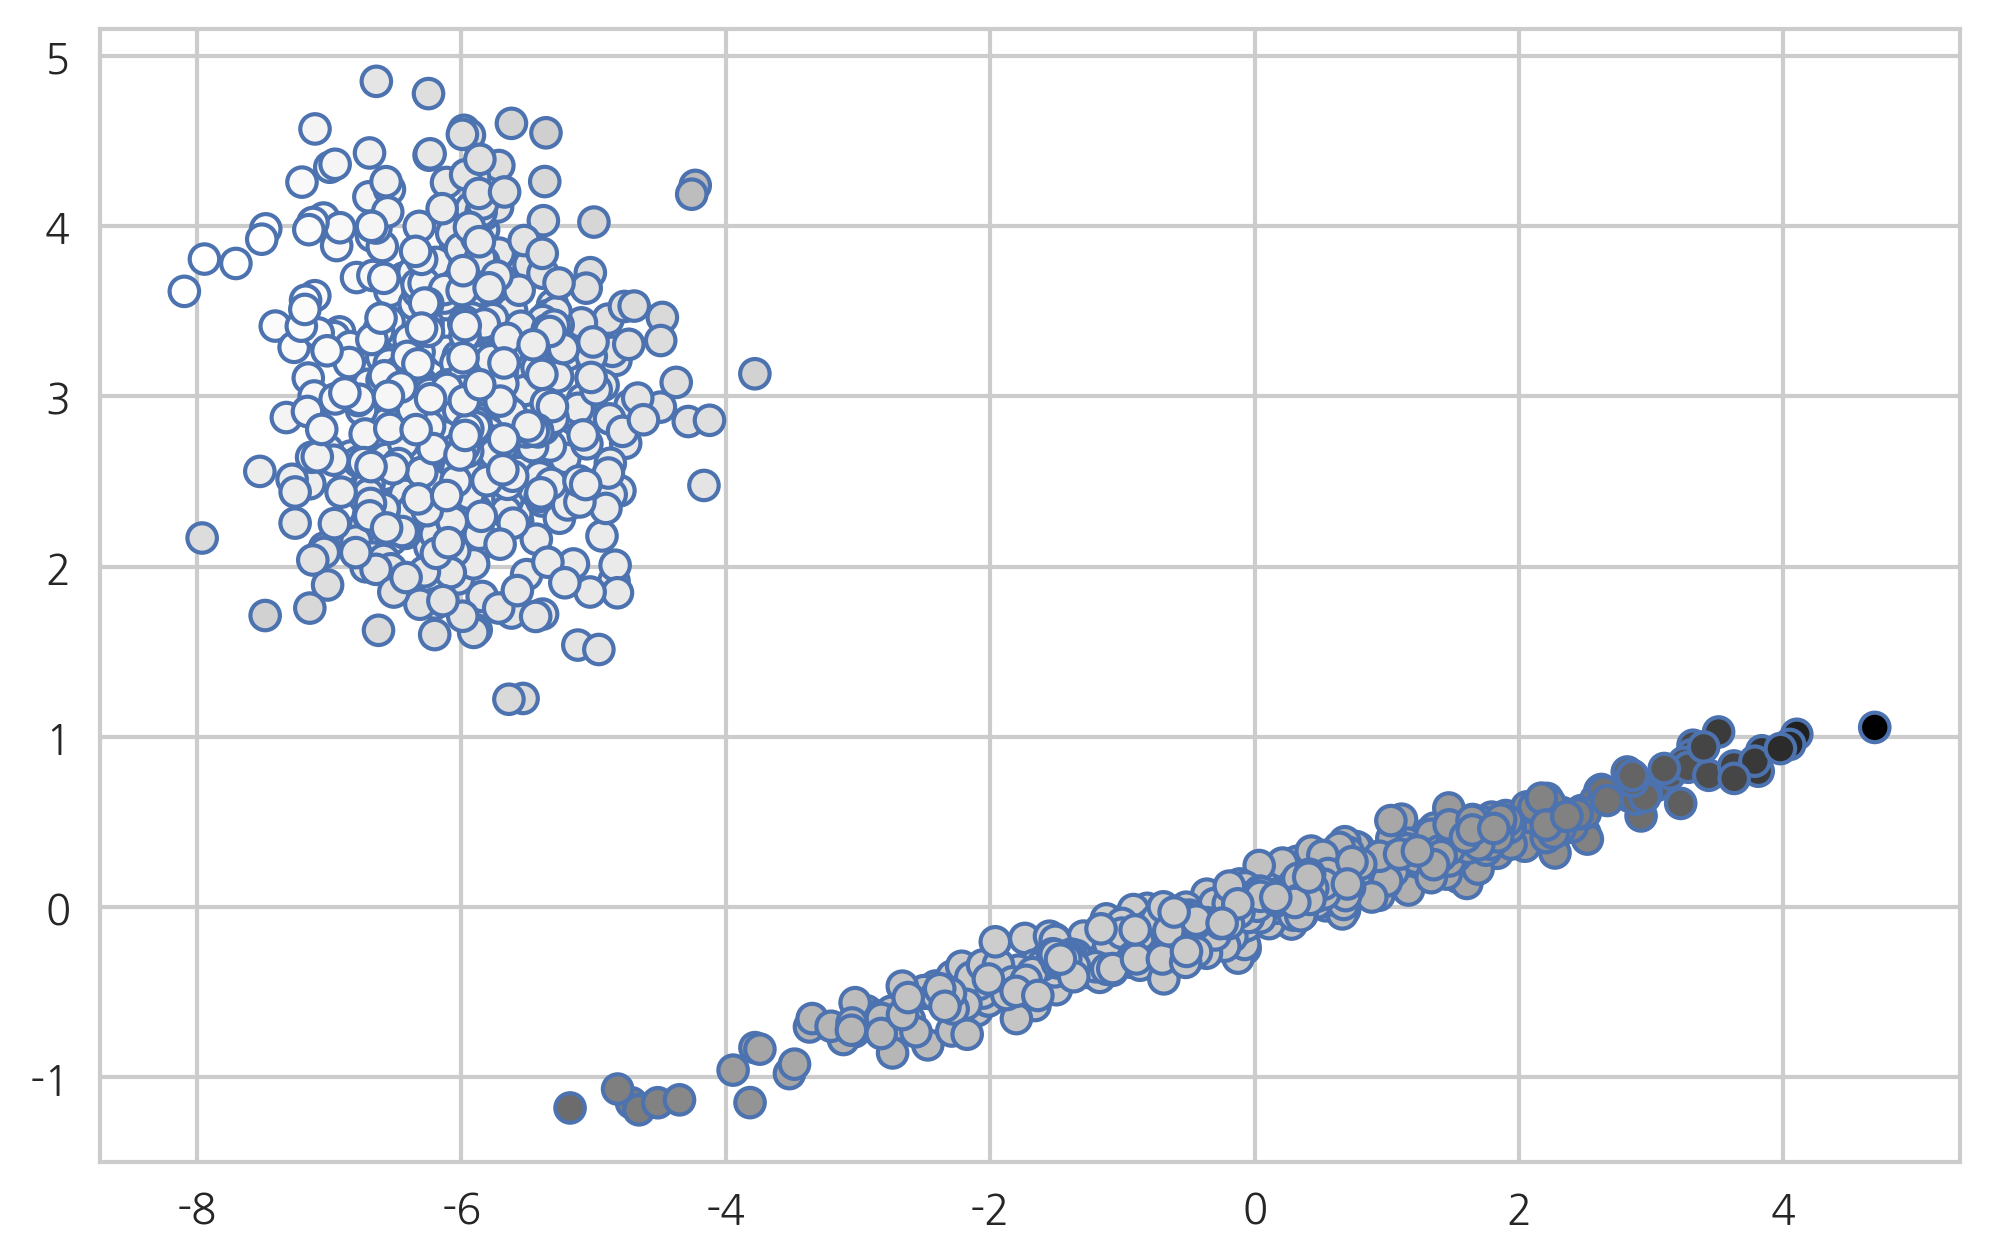

In [6]:
plt.scatter(X[:, 0], X[:, 1], s=50, linewidth=1, edgecolors="b", cmap=plt.cm.binary, c=gamma[:, 0])
plt.show()

In [7]:
def plot_gaussianmixture(n, k=10):
    model = GaussianMixture(n_components=2, init_params='random', random_state=1, tol=1e-9, max_iter=n)
    model.fit(X)
    gamma = model.predict_proba(X)
    plt.scatter(X[:, 0], X[:, 1], s=50, linewidth=1, edgecolors="b", cmap=plt.cm.binary, c=gamma[:, 0])
    plt.show()
    print(gamma)
    return model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\mixture\base.py:237: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


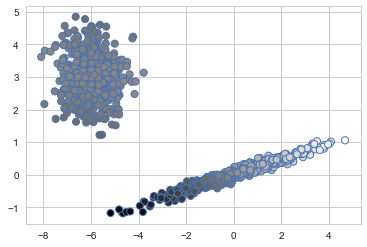

[[0.43556939 0.56443061]
 [0.21357637 0.78642363]
 [0.63552649 0.36447351]
 ...
 [0.49031073 0.50968927]
 [0.48691548 0.51308452]
 [0.52315843 0.47684157]]


In [8]:
plot_gaussianmixture(5);

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\mixture\base.py:237: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


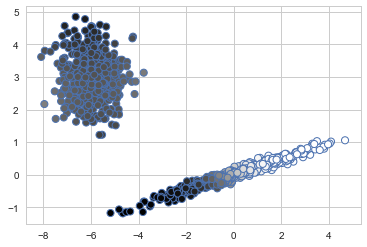

[[1.40176717e-01 8.59823283e-01]
 [8.70141747e-05 9.99912986e-01]
 [8.77659515e-01 1.22340485e-01]
 ...
 [6.68491533e-01 3.31508467e-01]
 [6.42161325e-01 3.57838675e-01]
 [6.23044163e-01 3.76955837e-01]]


In [9]:
plot_gaussianmixture(10);

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\mixture\base.py:237: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


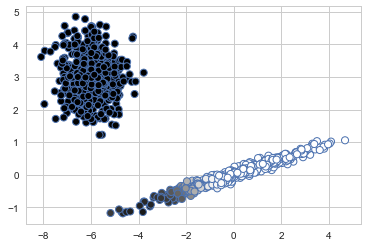

[[2.01690253e-04 9.99798310e-01]
 [1.11838807e-12 1.00000000e+00]
 [3.59379570e-01 6.40620430e-01]
 ...
 [9.99990078e-01 9.92235711e-06]
 [9.99978545e-01 2.14550271e-05]
 [9.98089808e-01 1.91019212e-03]]


In [10]:
plot_gaussianmixture(15);

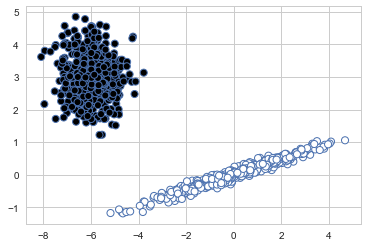

[[3.78057820e-025 1.00000000e+000]
 [1.26363039e-046 1.00000000e+000]
 [9.98142144e-015 1.00000000e+000]
 ...
 [1.00000000e+000 0.00000000e+000]
 [1.00000000e+000 0.00000000e+000]
 [1.00000000e+000 3.37452058e-313]]


In [12]:
plot_gaussianmixture(20);

베르누이 분포이면서 시계열 분포를 보이는 것 - 히든 마코프 모형